# Assignment 5: MNIST Classification using MultiLayer Perceptron

## 1. Import libraries and dataset, and do Exploratory Data Analysis

Import libraries.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision

from torchvision.datasets import MNIST
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

Load the MNIST dataset with Torchvision API and split it into a train dataset & test dataset. Also convert MNIST dataset images to vector tensor.

In [2]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

Visualize the dataset as actual images, by plotting them using `matplotlib`.

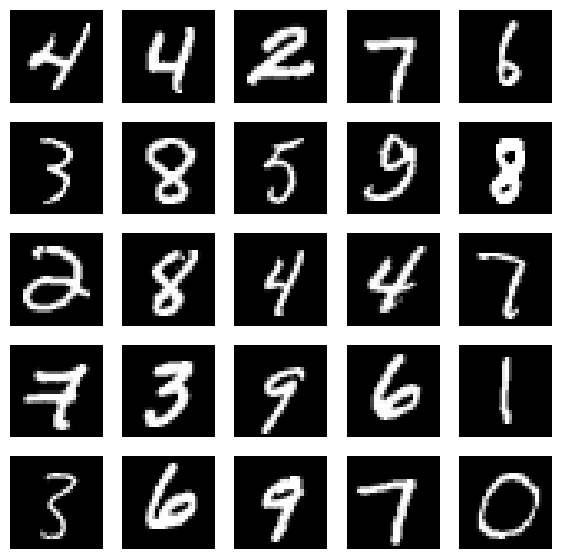

In [3]:
figure = plt.figure(figsize=(7, 7))
cols, rows = 5, 5

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_trainset), size=(1,)).item()
    img, label = mnist_trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    
plt.show() 

## 2. Preprocess dataset.

Check the length of the MNIST training set & test set.

In [4]:
len(mnist_trainset)

60000

In [5]:
len(mnist_testset)

10000

The image is converted to a 28*28 tensor. 
The first dimension is used to keep track of the color channels. Since images in the MNIST dataset are grayscale, there's just one channel.

In [6]:
image_tensor, label = mnist_trainset[0]
print(image_tensor.shape, label)

image_tensor, label = mnist_testset[0]
print(image_tensor.shape, label)

torch.Size([1, 28, 28]) 5
torch.Size([1, 28, 28]) 7


Use `DataLoader` to iterate over the dataset in mini batches instead of one observation at a time, and to shuffle  the data while training the models.

In [7]:
loaded_train = DataLoader(mnist_trainset, batch_size=64)
loaded_test = DataLoader(mnist_testset, batch_size=64)

## 3. Build the MLP model

Feed vector tensors to linear layers & activation functions.

In [8]:
device = "cuda"
print(device)

class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.flatten = nn.Flatten()
        self.linear=nn.Sequential(
            nn.Linear(28*28,512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Dropout(p=0.28),
            nn.Linear(512,10),
            nn.Sigmoid()   
        )
    def forward(self,x):
        x = self.flatten(x)
        out = self.linear(x)
        return out  
    
model = MLP().to(device)
print(model)    

cuda
MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.28, inplace=False)
    (5): Linear(in_features=512, out_features=10, bias=True)
    (6): Sigmoid()
  )
)


Use the loss function to compute the difference between predict label & ground truth label.

In [9]:
loss_function = nn.CrossEntropyLoss()

Use optimizers to make the model converge.

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

## 4. Train & test the model

- Implement a `train` function, that consists of looping through the data one batch at a time, using the optimizer to adjust the model, and computing the prediction and the loss. 
- Use `backward()` function to get the gradient of each Linear Layer's parameters.
- Keep track of the number of the batch so we can print the loss and the current batch every 100 iterations.

In [11]:
def train(dataloader, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X.to('cuda'))
        loss = loss_fn(pred, y.to('cuda'))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    return loss.item()        

- The `test` function computes the accuracy and the loss, using the test set.

In [12]:
def test(dataloader, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X.to("cuda"))
            test_loss += loss_fn(pred, y.to('cuda')).item()
            correct += (pred.argmax(1) == y.to('cuda')).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return test_loss 

In [13]:
epochs = range(1, 11)

train_loss_vals = []
test_loss_vals = []

for t in epochs:
    print(f"Epoch {t}\n-------------------------------")
    train_loss = train(loaded_train, loss_function, optimizer)
    test_loss= test(loaded_test, loss_function)

    train_loss_vals.append(train_loss)
    test_loss_vals.append(test_loss)

    
print("Done!")

Epoch 1
-------------------------------
loss: 2.302194  [   64/60000]
loss: 1.552959  [ 6464/60000]
loss: 1.539170  [12864/60000]
loss: 1.527411  [19264/60000]
loss: 1.525473  [25664/60000]
loss: 1.530488  [32064/60000]
loss: 1.512820  [38464/60000]
loss: 1.514968  [44864/60000]
loss: 1.522738  [51264/60000]
loss: 1.511900  [57664/60000]
Test Error: 
 Accuracy: 95.4%, Avg loss: 1.501656 

Epoch 2
-------------------------------
loss: 1.487405  [   64/60000]
loss: 1.509783  [ 6464/60000]
loss: 1.487299  [12864/60000]
loss: 1.498845  [19264/60000]
loss: 1.486361  [25664/60000]
loss: 1.493232  [32064/60000]
loss: 1.484947  [38464/60000]
loss: 1.504437  [44864/60000]
loss: 1.492816  [51264/60000]
loss: 1.489903  [57664/60000]
Test Error: 
 Accuracy: 95.7%, Avg loss: 1.495044 

Epoch 3
-------------------------------
loss: 1.487218  [   64/60000]
loss: 1.484921  [ 6464/60000]
loss: 1.481154  [12864/60000]
loss: 1.481547  [19264/60000]
loss: 1.484313  [25664/60000]
loss: 1.485132  [32064/600

Save & load model.

In [14]:
torch.save(model, "model.pth")
model = torch.load("model.pth")

## 5. Make predictions

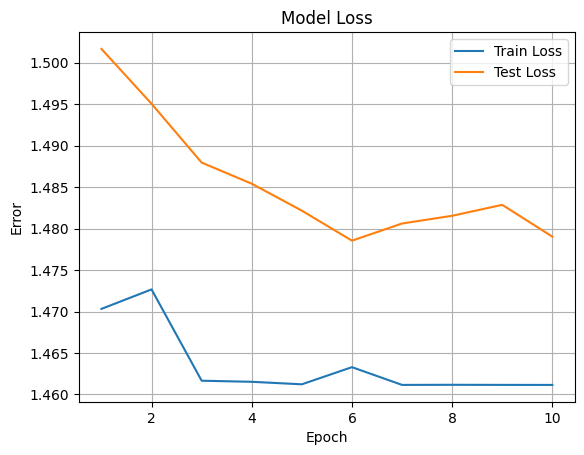

In [15]:

plt.plot(epochs, train_loss_vals, label="Train Loss")
plt.plot(epochs, test_loss_vals, label="Test Loss")
plt.title("Model Loss")
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()